# Project: Dog vs Cat Classification

In [2]:
from pathlib import Path
import os
import torch
from torch import nn

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
data_path = Path("data/")
train_path = data_path / "train"
test_path = data_path / "test"

train_path, test_path

(WindowsPath('data/train'), WindowsPath('data/test'))

In [5]:
from PIL import Image
import random
import matplotlib.pyplot as plt
import numpy as np

Text(0.5, 1.0, 'Cat, Shape: (369, 500, 3)')

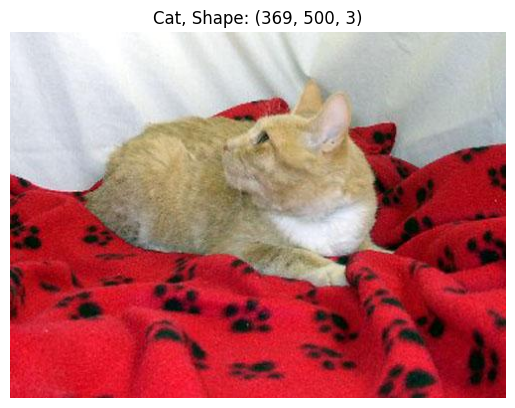

In [6]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
image_path_list = list(data_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)
img_is_array = np.asarray(img)

plt.imshow(img)
plt.axis(False)
plt.title(f"{image_class}, Shape: {img_is_array.shape}")

In [7]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [8]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [9]:
transformed_image = data_transform(img)
transformed_image

tensor([[[0.9059, 0.8784, 0.8627,  ..., 0.7765, 0.7804, 0.7686],
         [0.9098, 0.8863, 0.8588,  ..., 0.7765, 0.7765, 0.7686],
         [0.9176, 0.8941, 0.8627,  ..., 0.7804, 0.7725, 0.7608],
         ...,
         [0.8902, 0.8824, 0.8824,  ..., 0.4235, 0.4157, 0.5882],
         [0.8706, 0.8706, 0.8667,  ..., 0.5490, 0.5608, 0.5882],
         [0.8510, 0.8588, 0.8627,  ..., 0.5922, 0.5765, 0.6000]],

        [[0.9176, 0.8902, 0.8784,  ..., 0.8000, 0.8000, 0.8000],
         [0.9216, 0.8980, 0.8745,  ..., 0.8000, 0.8000, 0.7961],
         [0.9294, 0.9059, 0.8784,  ..., 0.8078, 0.8000, 0.7882],
         ...,
         [0.1294, 0.1098, 0.1098,  ..., 0.0196, 0.0275, 0.0196],
         [0.1098, 0.0980, 0.1176,  ..., 0.0235, 0.0196, 0.0275],
         [0.0941, 0.0863, 0.1059,  ..., 0.0275, 0.0196, 0.0235]],

        [[0.9529, 0.9255, 0.9137,  ..., 0.8118, 0.8039, 0.7804],
         [0.9569, 0.9333, 0.9098,  ..., 0.8078, 0.7922, 0.7686],
         [0.9647, 0.9412, 0.9137,  ..., 0.8078, 0.7765, 0.

Text(0.5, 1.0, 'Cat, Shape: torch.Size([3, 64, 64])')

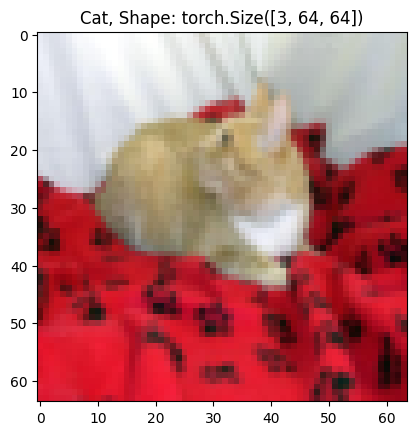

In [10]:
plt.imshow(transformed_image.permute(1, 2, 0))
plt.title(f"{image_class}, Shape: {transformed_image.shape}")

# Loading data using 'ImageFolder'

In [11]:
train_data = datasets.ImageFolder(root=train_path,
                                  transform=data_transform)

test_data = datasets.ImageFolder(root=test_path,
                                 transform=test_data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 13840
     Root location: data\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 3156
     Root location: data\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [12]:
# Get class names as list
class_names = train_data.classes
class_names

['Cat', 'Dog']

In [13]:
# Get class names as dictionary 
class_dict = train_data.class_to_idx
class_dict

{'Cat': 0, 'Dog': 1}

In [14]:
len(train_data), len(test_data)

(13840, 3156)

# Turn loaded images into 'DataLoader'

In [15]:
BATCH_SIZE = 32
NUM_WORKERS = 0

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x2a0e462dee0>,
 <torch.utils.data.dataloader.DataLoader at 0x2a0e462d850>)

In [16]:
img_custom, label_custom = next(iter(train_dataloader))

img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [17]:
class DogVsCat(nn.Module):
    def __init__(self, input_shape, hidden_layers, output_shape):
        super().__init__()

        self.conv_block_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_layers,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.BatchNorm2d(num_features=hidden_layers),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Conv2d(in_channels=hidden_layers,
                      out_channels=hidden_layers * 2,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.BatchNorm2d(num_features=hidden_layers*2),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.conv_block_layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_layers*2,
                      out_channels=hidden_layers*2*2,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.BatchNorm2d(num_features=hidden_layers*2*2),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=hidden_layers*2*2,
                      out_channels=hidden_layers*2*2*2,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.BatchNorm2d(num_features=hidden_layers*2*2*2),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.classification = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_layers*16*16*8,
                      #out_features=output_shape
                      out_features=128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, output_shape)
        )

    def forward(self, x):
        #print(f"Shape: {x.shape}")
        x = self.conv_block_layer_1(x)
        #print(f"Shape: {x.shape}")
        x = self.conv_block_layer_2(x)
        #print(f"Shape: {x.shape}")
        x = self.classification(x)
        #print(f"Shape: {x.shape}")
        return x
        

In [18]:
model_0 = DogVsCat(input_shape=3, hidden_layers=16, output_shape=1).to(device)
model_0

DogVsCat(
  (conv_block_layer_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_layer_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6):

In [19]:
# Setup loss function and optimizer
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

loss_fn, optimizer

(BCEWithLogitsLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ))

In [20]:
# Check the correct shape on dummy tensor
dummy_input = torch.randn(32, 3, 64, 64)
output = model_0(dummy_input.to(device))
output

tensor([[ 1.2823],
        [ 0.3512],
        [ 0.6266],
        [ 0.7147],
        [ 0.0137],
        [ 0.6100],
        [ 0.6244],
        [ 0.4744],
        [-0.1860],
        [ 0.8139],
        [ 1.1230],
        [ 0.8489],
        [ 0.6259],
        [ 0.6490],
        [ 0.5949],
        [ 0.7442],
        [ 0.6300],
        [ 0.2604],
        [ 0.7945],
        [ 0.6078],
        [-0.1602],
        [ 0.8420],
        [ 0.1246],
        [ 1.0608],
        [ 1.2842],
        [ 1.1028],
        [ 0.6670],
        [ 0.7790],
        [ 0.0314],
        [ 0.2458],
        [ 0.5490],
        [-0.1560]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [21]:
from tqdm import tqdm
import time

In [22]:
epochs = 1

start_time = time.time()

results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

for epoch in tqdm(range(epochs)):

    model_0.train()
    train_loss, train_acc = 0, 0
    
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)

        y = y.unsqueeze(dim=1).float()
        
        y_pred = model_0(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = (torch.sigmoid(y_pred) > 0.5).float()
        train_acc += (y_pred_class==y).sum().item() / len(y_pred)

    train_loss /= len(train_dataloader)
    train_acc = (train_acc / len(train_dataloader)) * 100
    
    model_0.eval()
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():
        for batch, (X, y) in enumerate(test_dataloader):
            X, y = X.to(device), y.to(device)

            y = y.unsqueeze(dim=1).float()
        
            test_pred = model_0(X)

            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            test_pred_class = (torch.sigmoid(test_pred) > 0.5).float()
            test_acc += (test_pred_class==y).sum().item() / len(test_pred)
    
        test_loss /= len(test_dataloader)
        test_acc = (test_acc / len(test_dataloader)) * 100

    print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f} | Test Loss: {test_loss}, Test Accuracy: {test_acc}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    


end_time = time.time()
train_time = end_time - start_time

print(f"Total time: {train_time}")

  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\piotr\anaconda3\envs\test\lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 1/1 [00:52<00:00, 52.71s/it]

Epoch: 0 | Train Loss: 0.8668, Train Accuracy: 53.30 | Test Loss: 0.6815916438295384, Test Accuracy: 57.2790404040404
Total time: 52.71405005455017


# Plot model_0 results

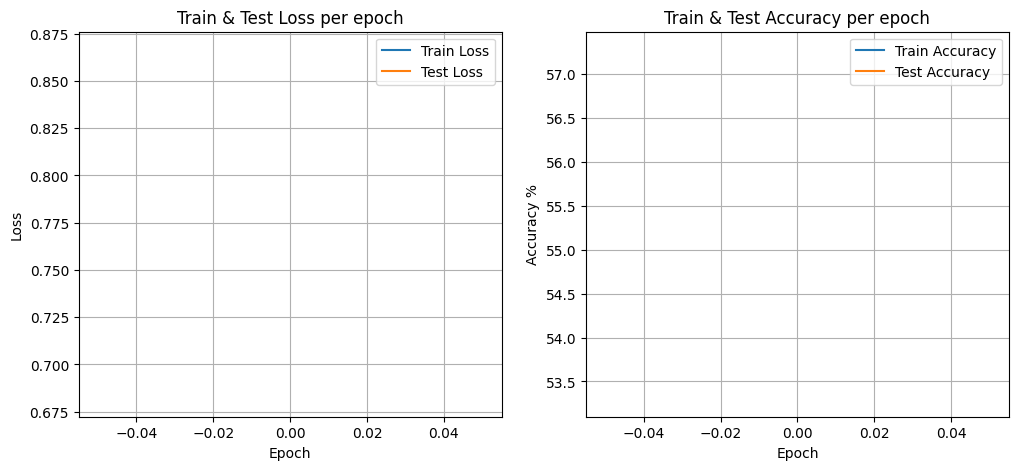

In [23]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), results["train_loss"], label="Train Loss")
plt.plot(range(epochs), results["test_loss"], label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Test Loss per epoch")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), results["train_acc"], label="Train Accuracy")
plt.plot(range(epochs), results["test_acc"], label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy %")
plt.title("Train & Test Accuracy per epoch")
plt.legend()
plt.grid()



In [24]:
print(len(results["train_loss"]), len(results["test_loss"]))
print(len(results["train_acc"]), len(results["test_acc"]))

1 1
1 1


In [25]:
# Build train and test function to make training easier
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim,
               device=device):

    train_loss, correct_preds, total_samples = 0, 0, 0
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y = y.unsqueeze(dim=1).float()
        
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
        
        y_pred_class = (torch.sigmoid(y_pred) > 0.5).float()
        #train_acc += (y_pred_class==y).sum().item() / len(y_pred)
        correct_preds += (y_pred_class == y).sum().item()
        total_samples += y.size(0)

    train_loss /= len(dataloader)
    #train_acc = (train_acc / len(dataloader)) * 100
    train_acc = (correct_preds / total_samples) * 100
    
    return train_loss, train_acc

In [26]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):

    test_loss, correct_preds, total_samples = 0, 0, 0
    model.eval()
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            y = y.unsqueeze(dim=1).float()
        
            test_pred = model(X)

            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            test_pred_class = (torch.sigmoid(test_pred) > 0.5).float()
            #test_acc += (test_pred_class==y).sum().item() / len(test_pred)
            correct_preds += (test_pred_class == y).sum().item()
            total_samples += y.size(0)
    
    test_loss /= len(dataloader)
    #test_acc = (test_acc / len(dataloader)) * 100
    test_acc = (correct_preds / total_samples) * 100
    return test_loss, test_acc

# Augmentation data

In [27]:
train_data_transform_augmentation = transforms.Compose([
    #transforms.Resize(size=(64, 64)),
    transforms.RandomResizedCrop(size=(64, 64), scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=25),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    #transforms.RandomAffine(degrees=15, translate=(1, 1)),
    #transforms.TrivialAugmentWide(num_magnitude_bins=31), # used to differentiate the data
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

test_data = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
train_data_transform_augmentation, test_data

(Compose(
     RandomResizedCrop(size=(64, 64), scale=(0.9, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
     RandomHorizontalFlip(p=0.5)
     RandomRotation(degrees=[-25.0, 25.0], interpolation=nearest, expand=False, fill=0)
     ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.05, 0.05))
     GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0))
     ToTensor()
     Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
 ),
 Compose(
     Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
     ToTensor()
     Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
 ))

In [28]:
train_data_augmentation = datasets.ImageFolder(root=train_path,
                                               transform=train_data_transform_augmentation)
test_data_augmentation = datasets.ImageFolder(root=test_path,
                                              transform=test_data)

train_data_augmentation, test_data_augmentation

(Dataset ImageFolder
     Number of datapoints: 13840
     Root location: data\train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(64, 64), scale=(0.9, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
                RandomHorizontalFlip(p=0.5)
                RandomRotation(degrees=[-25.0, 25.0], interpolation=nearest, expand=False, fill=0)
                ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.05, 0.05))
                GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0))
                ToTensor()
                Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
            ),
 Dataset ImageFolder
     Number of datapoints: 3156
     Root location: data\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.

In [29]:
BATCH_SIZE = 64
NUM_WORKERS = 4

train_dataloader_augmentation = DataLoader(dataset=train_data_augmentation,
                                           batch_size=BATCH_SIZE,
                                           num_workers=NUM_WORKERS,
                                           shuffle=True)

test_dataloader_augmentation = DataLoader(dataset=test_data_augmentation,
                                          batch_size=BATCH_SIZE,
                                          num_workers=NUM_WORKERS,
                                          shuffle=False)

train_dataloader_augmentation, test_dataloader_augmentation

(<torch.utils.data.dataloader.DataLoader at 0x2a0cd302d60>,
 <torch.utils.data.dataloader.DataLoader at 0x2a0ce54deb0>)

In [30]:
len(class_names)

2

In [31]:
model_1 = DogVsCat(input_shape=3, hidden_layers=8, output_shape=1).to(device)
model_1

DogVsCat(
  (conv_block_layer_1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_layer_2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU

In [32]:
# Setup loss function and optimizer
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(params=model_1.parameters(), lr=0.001, weight_decay=0.01)
                             #lr=0.00025)
#optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01, momentum=0.9)
loss_fn, optimizer

(BCEWithLogitsLoss(),
 AdamW (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0.01
 ))

In [33]:
# Train model_1 on augmentation data
epochs = 100

start_time = time.time()

results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

for epoch in tqdm(range(epochs)):

    train_loss, train_acc = train_step(model=model_1,
               dataloader=train_dataloader_augmentation,
               loss_fn=loss_fn,
               optimizer=optimizer)

    test_loss, test_acc = test_step(model=model_1,
              dataloader=test_dataloader_augmentation,
              loss_fn=loss_fn)

    print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f} | Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    


end_time = time.time()
train_time = end_time - start_time

print(f"Total time: {train_time}")

  1%|          | 1/100 [00:56<1:32:50, 56.27s/it]

Epoch: 0 | Train Loss: 0.7802, Train Accuracy: 55.79 | Test Loss: 0.6525, Test Accuracy: 63.66


  2%|▏         | 2/100 [01:49<1:28:51, 54.41s/it]

Epoch: 1 | Train Loss: 0.6477, Train Accuracy: 61.65 | Test Loss: 0.6063, Test Accuracy: 70.53


  3%|▎         | 3/100 [02:41<1:26:11, 53.31s/it]

Epoch: 2 | Train Loss: 0.6294, Train Accuracy: 64.47 | Test Loss: 0.6058, Test Accuracy: 68.82


  4%|▍         | 4/100 [03:32<1:24:03, 52.54s/it]

Epoch: 3 | Train Loss: 0.6205, Train Accuracy: 64.46 | Test Loss: 0.5863, Test Accuracy: 70.06


  5%|▌         | 5/100 [04:24<1:22:41, 52.22s/it]

Epoch: 4 | Train Loss: 0.6090, Train Accuracy: 66.91 | Test Loss: 0.5774, Test Accuracy: 72.75


  6%|▌         | 6/100 [05:24<1:25:55, 54.84s/it]

Epoch: 5 | Train Loss: 0.6028, Train Accuracy: 67.20 | Test Loss: 0.5488, Test Accuracy: 73.45


  7%|▋         | 7/100 [06:18<1:24:29, 54.51s/it]

Epoch: 6 | Train Loss: 0.5982, Train Accuracy: 67.28 | Test Loss: 0.5427, Test Accuracy: 72.85


  8%|▊         | 8/100 [07:05<1:20:18, 52.38s/it]

Epoch: 7 | Train Loss: 0.5879, Train Accuracy: 69.15 | Test Loss: 0.5457, Test Accuracy: 74.24


  9%|▉         | 9/100 [07:55<1:18:03, 51.47s/it]

Epoch: 8 | Train Loss: 0.5810, Train Accuracy: 69.83 | Test Loss: 0.5516, Test Accuracy: 72.05


 10%|█         | 10/100 [08:44<1:16:15, 50.83s/it]

Epoch: 9 | Train Loss: 0.5659, Train Accuracy: 70.70 | Test Loss: 0.5074, Test Accuracy: 75.86


 11%|█         | 11/100 [09:31<1:13:41, 49.68s/it]

Epoch: 10 | Train Loss: 0.5563, Train Accuracy: 71.24 | Test Loss: 0.5217, Test Accuracy: 76.17


 12%|█▏        | 12/100 [10:19<1:11:53, 49.02s/it]

Epoch: 11 | Train Loss: 0.5553, Train Accuracy: 71.44 | Test Loss: 0.5110, Test Accuracy: 76.17


 13%|█▎        | 13/100 [11:06<1:10:17, 48.48s/it]

Epoch: 12 | Train Loss: 0.5527, Train Accuracy: 72.15 | Test Loss: 0.5084, Test Accuracy: 76.84


 14%|█▍        | 14/100 [11:54<1:09:00, 48.15s/it]

Epoch: 13 | Train Loss: 0.5456, Train Accuracy: 72.43 | Test Loss: 0.4915, Test Accuracy: 77.95


 15%|█▌        | 15/100 [12:53<1:12:53, 51.46s/it]

Epoch: 14 | Train Loss: 0.5415, Train Accuracy: 73.16 | Test Loss: 0.4905, Test Accuracy: 77.92


 16%|█▌        | 16/100 [13:41<1:10:41, 50.49s/it]

Epoch: 15 | Train Loss: 0.5377, Train Accuracy: 73.32 | Test Loss: 0.4933, Test Accuracy: 77.12


 17%|█▋        | 17/100 [14:29<1:08:40, 49.65s/it]

Epoch: 16 | Train Loss: 0.5349, Train Accuracy: 73.32 | Test Loss: 0.4595, Test Accuracy: 78.99


 18%|█▊        | 18/100 [15:16<1:07:05, 49.09s/it]

Epoch: 17 | Train Loss: 0.5268, Train Accuracy: 74.44 | Test Loss: 0.5014, Test Accuracy: 75.29


 19%|█▉        | 19/100 [16:05<1:06:00, 48.89s/it]

Epoch: 18 | Train Loss: 0.5231, Train Accuracy: 74.89 | Test Loss: 0.5186, Test Accuracy: 73.45


 20%|██        | 20/100 [16:54<1:05:20, 49.00s/it]

Epoch: 19 | Train Loss: 0.5256, Train Accuracy: 74.36 | Test Loss: 0.4615, Test Accuracy: 79.88


 21%|██        | 21/100 [17:41<1:03:53, 48.52s/it]

Epoch: 20 | Train Loss: 0.5145, Train Accuracy: 74.59 | Test Loss: 0.4743, Test Accuracy: 77.85


 22%|██▏       | 22/100 [18:33<1:04:06, 49.32s/it]

Epoch: 21 | Train Loss: 0.5102, Train Accuracy: 75.22 | Test Loss: 0.4470, Test Accuracy: 80.26


 23%|██▎       | 23/100 [19:33<1:07:21, 52.49s/it]

Epoch: 22 | Train Loss: 0.5120, Train Accuracy: 75.29 | Test Loss: 0.4733, Test Accuracy: 77.06


 24%|██▍       | 24/100 [20:24<1:06:04, 52.16s/it]

Epoch: 23 | Train Loss: 0.5022, Train Accuracy: 75.69 | Test Loss: 0.4341, Test Accuracy: 81.18


 25%|██▌       | 25/100 [21:15<1:04:55, 51.94s/it]

Epoch: 24 | Train Loss: 0.4960, Train Accuracy: 76.22 | Test Loss: 0.4489, Test Accuracy: 80.10


 26%|██▌       | 26/100 [22:05<1:03:13, 51.26s/it]

Epoch: 25 | Train Loss: 0.4951, Train Accuracy: 76.11 | Test Loss: 0.4322, Test Accuracy: 81.05


 27%|██▋       | 27/100 [22:53<1:01:20, 50.41s/it]

Epoch: 26 | Train Loss: 0.4968, Train Accuracy: 76.20 | Test Loss: 0.4326, Test Accuracy: 79.75


 28%|██▊       | 28/100 [23:42<59:44, 49.79s/it]  

Epoch: 27 | Train Loss: 0.4950, Train Accuracy: 76.29 | Test Loss: 0.4385, Test Accuracy: 79.56


 29%|██▉       | 29/100 [24:30<58:28, 49.41s/it]

Epoch: 28 | Train Loss: 0.4837, Train Accuracy: 76.69 | Test Loss: 0.4244, Test Accuracy: 80.10


 30%|███       | 30/100 [25:19<57:13, 49.04s/it]

Epoch: 29 | Train Loss: 0.4905, Train Accuracy: 76.78 | Test Loss: 0.4082, Test Accuracy: 81.37


 31%|███       | 31/100 [26:11<57:25, 49.94s/it]

Epoch: 30 | Train Loss: 0.4806, Train Accuracy: 76.78 | Test Loss: 0.4865, Test Accuracy: 75.57


 32%|███▏      | 32/100 [27:00<56:23, 49.75s/it]

Epoch: 31 | Train Loss: 0.4764, Train Accuracy: 77.64 | Test Loss: 0.4687, Test Accuracy: 78.77


 33%|███▎      | 33/100 [27:48<55:04, 49.32s/it]

Epoch: 32 | Train Loss: 0.4743, Train Accuracy: 77.30 | Test Loss: 0.4038, Test Accuracy: 82.86


 34%|███▍      | 34/100 [28:41<55:23, 50.35s/it]

Epoch: 33 | Train Loss: 0.4724, Train Accuracy: 77.39 | Test Loss: 0.3899, Test Accuracy: 83.08


 35%|███▌      | 35/100 [29:29<53:46, 49.64s/it]

Epoch: 34 | Train Loss: 0.4671, Train Accuracy: 78.41 | Test Loss: 0.3773, Test Accuracy: 83.27


 36%|███▌      | 36/100 [30:19<52:57, 49.64s/it]

Epoch: 35 | Train Loss: 0.4663, Train Accuracy: 78.14 | Test Loss: 0.3692, Test Accuracy: 84.41


 37%|███▋      | 37/100 [31:19<55:30, 52.87s/it]

Epoch: 36 | Train Loss: 0.4653, Train Accuracy: 78.19 | Test Loss: 0.3972, Test Accuracy: 81.43


 38%|███▊      | 38/100 [32:15<55:44, 53.95s/it]

Epoch: 37 | Train Loss: 0.4595, Train Accuracy: 78.23 | Test Loss: 0.3828, Test Accuracy: 82.79


 39%|███▉      | 39/100 [33:12<55:34, 54.66s/it]

Epoch: 38 | Train Loss: 0.4601, Train Accuracy: 78.53 | Test Loss: 0.4059, Test Accuracy: 81.56


 40%|████      | 40/100 [34:04<53:53, 53.89s/it]

Epoch: 39 | Train Loss: 0.4600, Train Accuracy: 78.79 | Test Loss: 0.3635, Test Accuracy: 84.00


 41%|████      | 41/100 [34:53<51:38, 52.52s/it]

Epoch: 40 | Train Loss: 0.4454, Train Accuracy: 79.42 | Test Loss: 0.3829, Test Accuracy: 81.72


 42%|████▏     | 42/100 [35:41<49:26, 51.14s/it]

Epoch: 41 | Train Loss: 0.4583, Train Accuracy: 78.89 | Test Loss: 0.3691, Test Accuracy: 83.84


 43%|████▎     | 43/100 [36:28<47:29, 50.00s/it]

Epoch: 42 | Train Loss: 0.4487, Train Accuracy: 79.08 | Test Loss: 0.3858, Test Accuracy: 81.78


 44%|████▍     | 44/100 [37:16<46:06, 49.41s/it]

Epoch: 43 | Train Loss: 0.4490, Train Accuracy: 78.98 | Test Loss: 0.3651, Test Accuracy: 84.60


 45%|████▌     | 45/100 [38:04<44:51, 48.93s/it]

Epoch: 44 | Train Loss: 0.4474, Train Accuracy: 79.26 | Test Loss: 0.3698, Test Accuracy: 84.03


 46%|████▌     | 46/100 [38:52<43:47, 48.66s/it]

Epoch: 45 | Train Loss: 0.4456, Train Accuracy: 79.02 | Test Loss: 0.3412, Test Accuracy: 85.71


 47%|████▋     | 47/100 [39:40<42:43, 48.37s/it]

Epoch: 46 | Train Loss: 0.4401, Train Accuracy: 79.91 | Test Loss: 0.3493, Test Accuracy: 84.35


 48%|████▊     | 48/100 [40:29<42:02, 48.51s/it]

Epoch: 47 | Train Loss: 0.4496, Train Accuracy: 79.03 | Test Loss: 0.3487, Test Accuracy: 84.66


 49%|████▉     | 49/100 [41:17<41:07, 48.38s/it]

Epoch: 48 | Train Loss: 0.4391, Train Accuracy: 79.83 | Test Loss: 0.3732, Test Accuracy: 82.92


 50%|█████     | 50/100 [42:07<40:40, 48.81s/it]

Epoch: 49 | Train Loss: 0.4351, Train Accuracy: 80.48 | Test Loss: 0.3493, Test Accuracy: 84.44


 51%|█████     | 51/100 [42:56<39:54, 48.87s/it]

Epoch: 50 | Train Loss: 0.4371, Train Accuracy: 80.03 | Test Loss: 0.3394, Test Accuracy: 85.58


 52%|█████▏    | 52/100 [43:46<39:20, 49.18s/it]

Epoch: 51 | Train Loss: 0.4323, Train Accuracy: 80.76 | Test Loss: 0.3457, Test Accuracy: 85.14


 53%|█████▎    | 53/100 [44:34<38:19, 48.92s/it]

Epoch: 52 | Train Loss: 0.4306, Train Accuracy: 80.55 | Test Loss: 0.3527, Test Accuracy: 84.73


 54%|█████▍    | 54/100 [45:24<37:51, 49.38s/it]

Epoch: 53 | Train Loss: 0.4321, Train Accuracy: 80.43 | Test Loss: 0.3166, Test Accuracy: 86.34


 55%|█████▌    | 55/100 [46:16<37:37, 50.17s/it]

Epoch: 54 | Train Loss: 0.4269, Train Accuracy: 80.53 | Test Loss: 0.3612, Test Accuracy: 84.60


 56%|█████▌    | 56/100 [47:06<36:40, 50.00s/it]

Epoch: 55 | Train Loss: 0.4276, Train Accuracy: 80.40 | Test Loss: 0.3419, Test Accuracy: 86.25


 57%|█████▋    | 57/100 [47:59<36:25, 50.83s/it]

Epoch: 56 | Train Loss: 0.4266, Train Accuracy: 80.10 | Test Loss: 0.3499, Test Accuracy: 85.36


 58%|█████▊    | 58/100 [48:49<35:32, 50.78s/it]

Epoch: 57 | Train Loss: 0.4194, Train Accuracy: 80.30 | Test Loss: 0.3472, Test Accuracy: 84.98


 59%|█████▉    | 59/100 [49:40<34:40, 50.74s/it]

Epoch: 58 | Train Loss: 0.4227, Train Accuracy: 80.18 | Test Loss: 0.3259, Test Accuracy: 85.90


 60%|██████    | 60/100 [50:32<34:04, 51.12s/it]

Epoch: 59 | Train Loss: 0.4131, Train Accuracy: 81.44 | Test Loss: 0.3222, Test Accuracy: 86.60


 61%|██████    | 61/100 [51:27<33:57, 52.23s/it]

Epoch: 60 | Train Loss: 0.4109, Train Accuracy: 81.32 | Test Loss: 0.3279, Test Accuracy: 86.95


 62%|██████▏   | 62/100 [52:19<33:07, 52.31s/it]

Epoch: 61 | Train Loss: 0.4125, Train Accuracy: 81.17 | Test Loss: 0.3534, Test Accuracy: 84.89


 63%|██████▎   | 63/100 [53:07<31:23, 50.91s/it]

Epoch: 62 | Train Loss: 0.4115, Train Accuracy: 81.18 | Test Loss: 0.3165, Test Accuracy: 86.22


 64%|██████▍   | 64/100 [54:02<31:20, 52.22s/it]

Epoch: 63 | Train Loss: 0.4115, Train Accuracy: 81.21 | Test Loss: 0.3285, Test Accuracy: 86.95


 65%|██████▌   | 65/100 [54:53<30:07, 51.63s/it]

Epoch: 64 | Train Loss: 0.4201, Train Accuracy: 80.61 | Test Loss: 0.3295, Test Accuracy: 85.46


 66%|██████▌   | 66/100 [55:49<30:04, 53.07s/it]

Epoch: 65 | Train Loss: 0.4031, Train Accuracy: 82.41 | Test Loss: 0.3056, Test Accuracy: 87.14


 67%|██████▋   | 67/100 [56:39<28:36, 52.01s/it]

Epoch: 66 | Train Loss: 0.4065, Train Accuracy: 81.97 | Test Loss: 0.3350, Test Accuracy: 85.30


 68%|██████▊   | 68/100 [57:26<27:04, 50.75s/it]

Epoch: 67 | Train Loss: 0.4152, Train Accuracy: 81.10 | Test Loss: 0.3123, Test Accuracy: 87.10


 69%|██████▉   | 69/100 [58:19<26:26, 51.17s/it]

Epoch: 68 | Train Loss: 0.4090, Train Accuracy: 81.61 | Test Loss: 0.3321, Test Accuracy: 84.98


 70%|███████   | 70/100 [59:06<25:03, 50.10s/it]

Epoch: 69 | Train Loss: 0.4060, Train Accuracy: 81.48 | Test Loss: 0.3421, Test Accuracy: 86.03


 71%|███████   | 71/100 [59:55<23:59, 49.63s/it]

Epoch: 70 | Train Loss: 0.4021, Train Accuracy: 82.23 | Test Loss: 0.3273, Test Accuracy: 86.88


 72%|███████▏  | 72/100 [1:00:43<22:56, 49.14s/it]

Epoch: 71 | Train Loss: 0.4033, Train Accuracy: 81.97 | Test Loss: 0.2952, Test Accuracy: 87.39


 73%|███████▎  | 73/100 [1:01:31<21:57, 48.78s/it]

Epoch: 72 | Train Loss: 0.4015, Train Accuracy: 81.98 | Test Loss: 0.3104, Test Accuracy: 86.79


 74%|███████▍  | 74/100 [1:02:20<21:10, 48.87s/it]

Epoch: 73 | Train Loss: 0.3949, Train Accuracy: 82.44 | Test Loss: 0.3203, Test Accuracy: 85.33


 75%|███████▌  | 75/100 [1:03:11<20:41, 49.65s/it]

Epoch: 74 | Train Loss: 0.4098, Train Accuracy: 81.48 | Test Loss: 0.3190, Test Accuracy: 87.42


 76%|███████▌  | 76/100 [1:04:07<20:32, 51.36s/it]

Epoch: 75 | Train Loss: 0.4004, Train Accuracy: 81.69 | Test Loss: 0.3160, Test Accuracy: 86.79


 77%|███████▋  | 77/100 [1:04:55<19:22, 50.55s/it]

Epoch: 76 | Train Loss: 0.3973, Train Accuracy: 82.25 | Test Loss: 0.3020, Test Accuracy: 87.33


 78%|███████▊  | 78/100 [1:05:55<19:35, 53.45s/it]

Epoch: 77 | Train Loss: 0.3970, Train Accuracy: 81.88 | Test Loss: 0.3118, Test Accuracy: 86.53


 79%|███████▉  | 79/100 [1:06:47<18:31, 52.93s/it]

Epoch: 78 | Train Loss: 0.4004, Train Accuracy: 82.52 | Test Loss: 0.3349, Test Accuracy: 86.28


 80%|████████  | 80/100 [1:07:44<18:03, 54.18s/it]

Epoch: 79 | Train Loss: 0.3952, Train Accuracy: 82.12 | Test Loss: 0.2975, Test Accuracy: 87.20


 81%|████████  | 81/100 [1:08:37<17:03, 53.87s/it]

Epoch: 80 | Train Loss: 0.3971, Train Accuracy: 82.26 | Test Loss: 0.3448, Test Accuracy: 83.81


 82%|████████▏ | 82/100 [1:09:27<15:44, 52.48s/it]

Epoch: 81 | Train Loss: 0.3942, Train Accuracy: 82.38 | Test Loss: 0.2921, Test Accuracy: 87.55


 83%|████████▎ | 83/100 [1:10:16<14:36, 51.57s/it]

Epoch: 82 | Train Loss: 0.3904, Train Accuracy: 82.36 | Test Loss: 0.3145, Test Accuracy: 86.47


 84%|████████▍ | 84/100 [1:11:10<13:55, 52.19s/it]

Epoch: 83 | Train Loss: 0.3923, Train Accuracy: 82.77 | Test Loss: 0.2982, Test Accuracy: 87.36


 85%|████████▌ | 85/100 [1:11:58<12:44, 50.95s/it]

Epoch: 84 | Train Loss: 0.3820, Train Accuracy: 83.20 | Test Loss: 0.3105, Test Accuracy: 86.85


 86%|████████▌ | 86/100 [1:12:45<11:38, 49.88s/it]

Epoch: 85 | Train Loss: 0.3968, Train Accuracy: 82.53 | Test Loss: 0.3007, Test Accuracy: 86.47


 87%|████████▋ | 87/100 [1:13:33<10:39, 49.22s/it]

Epoch: 86 | Train Loss: 0.3895, Train Accuracy: 82.72 | Test Loss: 0.3081, Test Accuracy: 86.82


 88%|████████▊ | 88/100 [1:14:20<09:43, 48.65s/it]

Epoch: 87 | Train Loss: 0.3900, Train Accuracy: 82.67 | Test Loss: 0.2903, Test Accuracy: 87.64


 89%|████████▉ | 89/100 [1:15:08<08:52, 48.43s/it]

Epoch: 88 | Train Loss: 0.3903, Train Accuracy: 82.49 | Test Loss: 0.3180, Test Accuracy: 85.65


 90%|█████████ | 90/100 [1:16:01<08:18, 49.90s/it]

Epoch: 89 | Train Loss: 0.3916, Train Accuracy: 82.90 | Test Loss: 0.2953, Test Accuracy: 87.01


 91%|█████████ | 91/100 [1:16:50<07:26, 49.63s/it]

Epoch: 90 | Train Loss: 0.3880, Train Accuracy: 82.78 | Test Loss: 0.2968, Test Accuracy: 86.53


 92%|█████████▏| 92/100 [1:17:42<06:40, 50.08s/it]

Epoch: 91 | Train Loss: 0.3915, Train Accuracy: 82.54 | Test Loss: 0.2993, Test Accuracy: 86.47


 93%|█████████▎| 93/100 [1:18:35<05:58, 51.16s/it]

Epoch: 92 | Train Loss: 0.3879, Train Accuracy: 83.37 | Test Loss: 0.3162, Test Accuracy: 86.76


 94%|█████████▍| 94/100 [1:19:26<05:05, 50.98s/it]

Epoch: 93 | Train Loss: 0.3816, Train Accuracy: 82.87 | Test Loss: 0.2899, Test Accuracy: 87.77


 95%|█████████▌| 95/100 [1:20:16<04:13, 50.64s/it]

Epoch: 94 | Train Loss: 0.3798, Train Accuracy: 83.00 | Test Loss: 0.3097, Test Accuracy: 85.93


 96%|█████████▌| 96/100 [1:21:06<03:21, 50.46s/it]

Epoch: 95 | Train Loss: 0.3799, Train Accuracy: 82.93 | Test Loss: 0.3113, Test Accuracy: 86.44


 97%|█████████▋| 97/100 [1:21:57<02:32, 50.88s/it]

Epoch: 96 | Train Loss: 0.3790, Train Accuracy: 83.20 | Test Loss: 0.2974, Test Accuracy: 87.77


 98%|█████████▊| 98/100 [1:22:46<01:40, 50.28s/it]

Epoch: 97 | Train Loss: 0.3704, Train Accuracy: 83.40 | Test Loss: 0.2876, Test Accuracy: 87.77


 99%|█████████▉| 99/100 [1:23:36<00:50, 50.10s/it]

Epoch: 98 | Train Loss: 0.3804, Train Accuracy: 83.22 | Test Loss: 0.2948, Test Accuracy: 86.82


100%|██████████| 100/100 [1:24:25<00:00, 50.66s/it]

Epoch: 99 | Train Loss: 0.3728, Train Accuracy: 83.85 | Test Loss: 0.3109, Test Accuracy: 86.22
Total time: 5065.87136721611


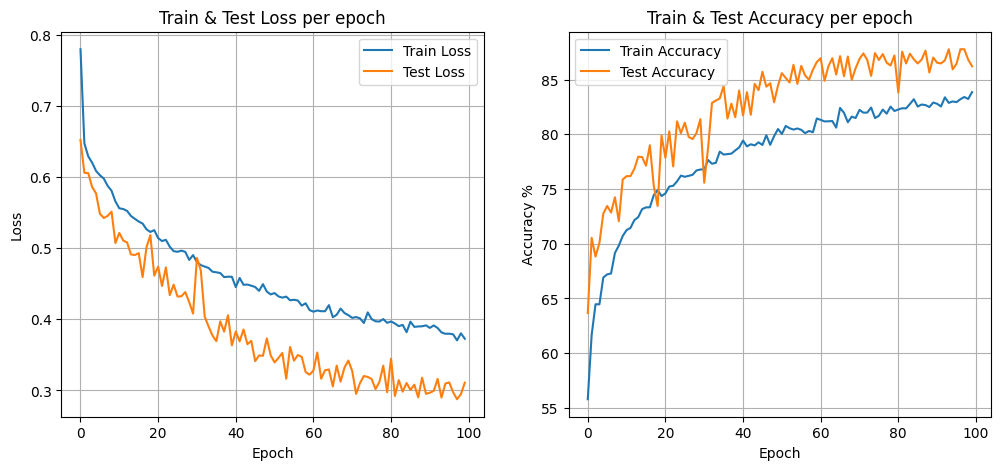

In [34]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), results["train_loss"], label="Train Loss")
plt.plot(range(epochs), results["test_loss"], label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Test Loss per epoch")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), results["train_acc"], label="Train Accuracy")
plt.plot(range(epochs), results["test_acc"], label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy %")
plt.title("Train & Test Accuracy per epoch")
plt.legend()
plt.grid()

In [35]:
from torch.utils.data import Subset

In [36]:
train_100_images = Subset(train_data_augmentation, range(100))
test_20_images = Subset(test_data_augmentation, range(20))

len(train_100_images), len(test_20_images)

(100, 20)

In [37]:
custom_image_path = data_path / "custom_image" / "corgi.jpg"
custom_image_path

WindowsPath('data/custom_image/corgi.jpg')

In [39]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path(data_path / "models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "CatDogClassifier.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: data\models\CatDogClassifier.pth
